## Imports

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, cohen_kappa_score
import pandas as pd
import os
import shutil
from IPython.display import FileLink
import numpy as np

## Parameters

In [3]:
BATCH_SIZE = 64
NUM_CLASSES = 3
LR = 1e-3
EPOCHS = 20
T = 10
AL_ROUNDS = 10
QUERY_SIZE = 1000
INITIAL_LABELED = 4000

SITE = 'B'
YEAR = 2020

np.random.seed(42)
torch.manual_seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Device: {DEVICE}')

Using Device: cuda


## Loading Files

In [4]:
X = np.load(f'/kaggle/input/data-usa/Site_{SITE}/x-{YEAR}.npy')
y = np.load(f'/kaggle/input/data-usa/Site_{SITE}/y-{YEAR}.npy')

print(f'Loaded Data of Site {SITE} - {YEAR}')
print(X.shape, y.shape)

Loaded Data of Site B - 2020
(1943716, 28, 6) (1943716,)


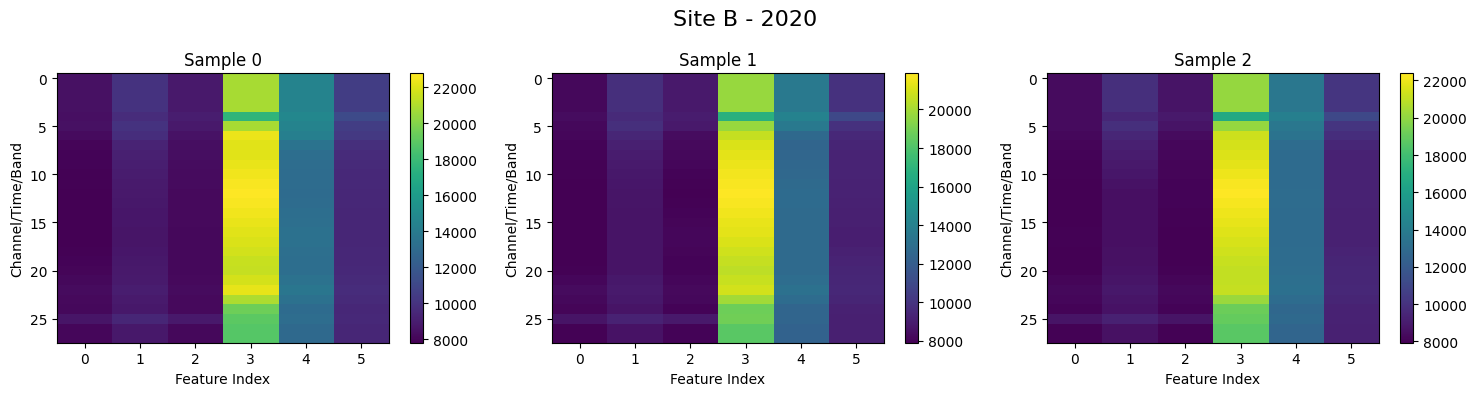

In [5]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = 9293.7332, Std = 1062.0828
Feature 1: Mean = 10402.3986, Std = 1328.2403
Feature 2: Mean = 10579.1004, Std = 1999.1082
Feature 3: Mean = 18968.7555, Std = 4274.7314
Feature 4: Mean = 16319.4431, Std = 3346.2848
Feature 5: Mean = 13205.7260, Std = 3494.6972

Global Mean: 13128.1928
Global Std Dev: 4500.1056


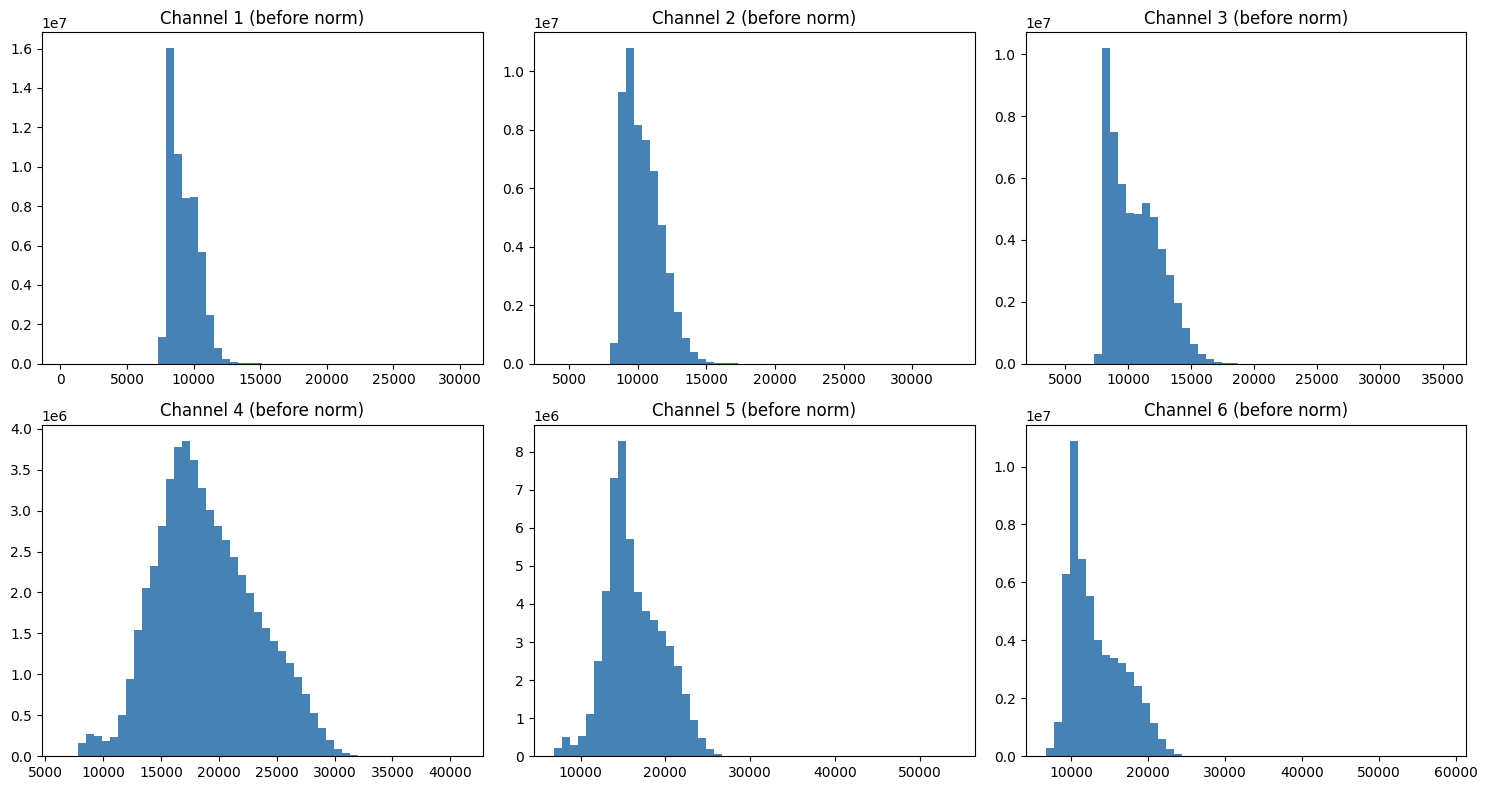

In [7]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# Before normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (before norm)')
plt.tight_layout()
plt.show()

## Pre Processing the Data

In [8]:
# Standardizing the input features across all timesteps and samples using Z-scores
# Compute per-feature mean and std across all samples and timesteps
feature_means = X.mean(axis=(0, 1))  # Shape: (6,)
feature_stds = X.std(axis=(0, 1))    # Shape: (6,)

# Reshape for broadcasting
feature_means = feature_means.reshape(1, 1, -1)  # Shape: (1, 1, 6)
feature_stds = feature_stds.reshape(1, 1, -1)    # Shape: (1, 1, 6)

# Standardize
X = ((X - feature_means) / feature_stds).astype(np.float32)

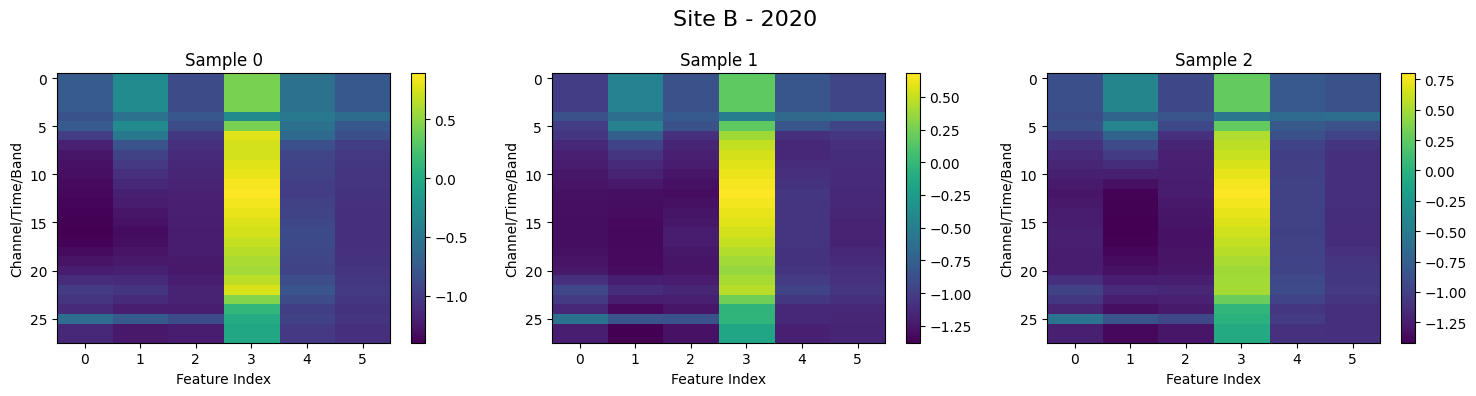

In [9]:
# Ploting the preprocessed feature maps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(3):
    im = axes[i].imshow(X[i], aspect='auto', cmap='viridis')
    axes[i].set_title(f"Sample {i}")
    axes[i].set_xlabel("Feature Index")
    axes[i].set_ylabel("Channel/Time/Band")
    fig.colorbar(im, ax=axes[i], orientation='vertical')

fig.suptitle(f"Site {SITE} - {YEAR}", fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
print(f'\n\n======= For Site {SITE} - {YEAR} =======')
feature_means = X.mean(axis=(0, 1))  # average over samples and features
feature_stds = X.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X.mean()
std = X.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= For Site B - 2020 =======
Feature 0: Mean = -0.0000, Std = 0.8846
Feature 1: Mean = -0.0000, Std = 0.8950
Feature 2: Mean = 0.0000, Std = 0.8862
Feature 3: Mean = 0.0001, Std = 0.9253
Feature 4: Mean = 0.0000, Std = 0.9230
Feature 5: Mean = 0.0000, Std = 0.8994

Global Mean: -0.0000
Global Std Dev: 1.0000


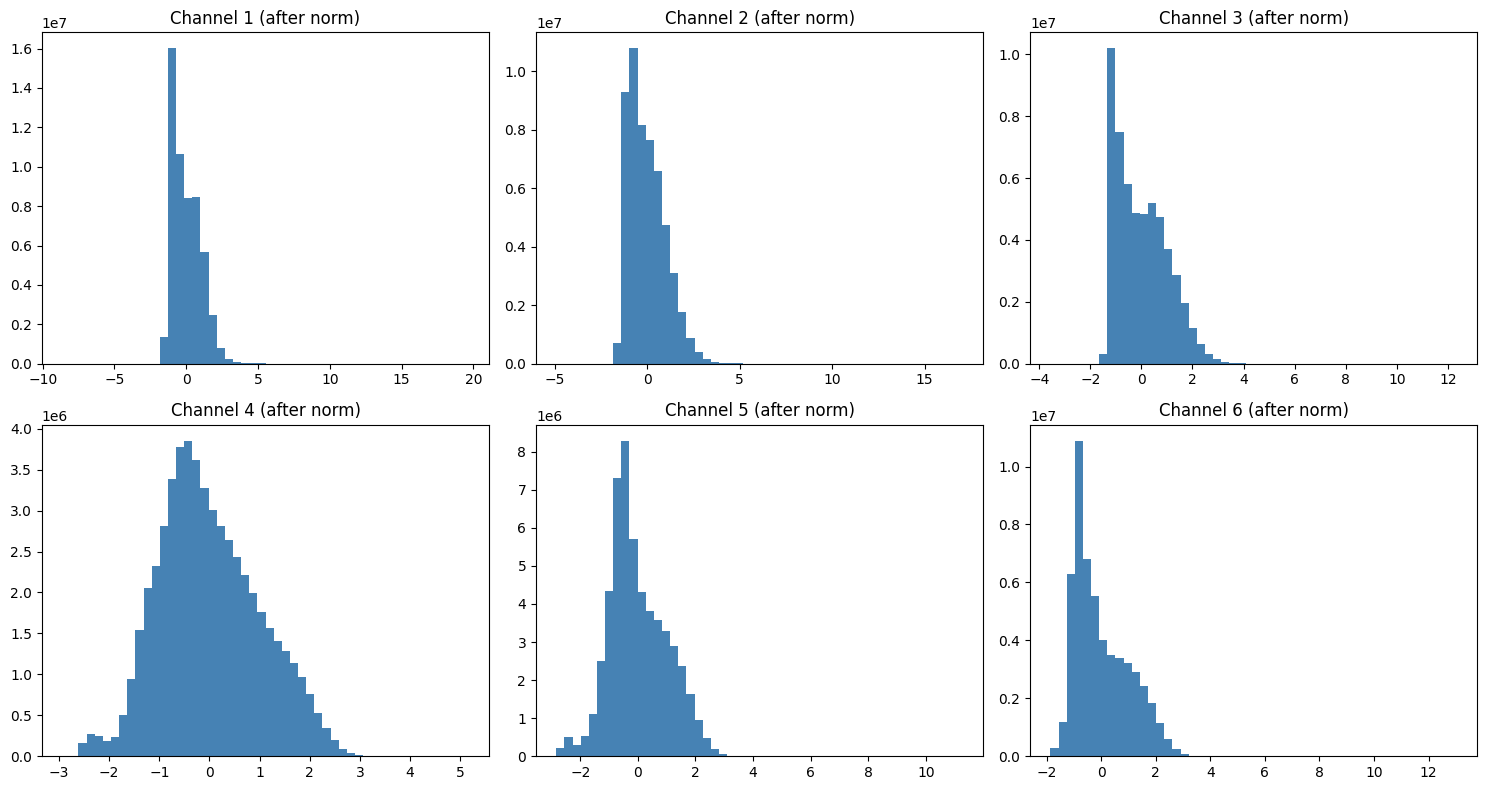

In [11]:
X_hist = X.reshape(-1, 6)  # shape: (N*T, 6)

# After normalization
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.ravel()

for i in range(6):
    axs[i].hist(X_hist[:, i], bins=50, color='steelblue', alpha=1)
    axs[i].set_title(f'Channel {i+1} (after norm)')
plt.tight_layout()
plt.show()

## Label Distribution



====== Label Distribution ======
Label     Count     Percentage
------------------------------
0         871034    44.81%
1         260775    13.42%
2         811907    41.77%

Total samples: 1943716


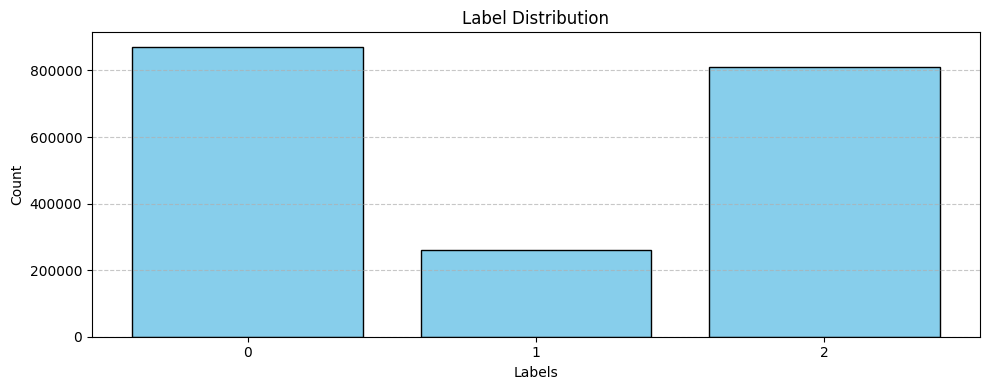

In [12]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution ======')
unique_labels, counts = np.unique(y, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Data Splits

In [13]:
# Taking only 25% percent of the data
X_subset, X_test, y_subset, y_test = train_test_split(X, y, test_size=0.75, stratify=y, random_state=42)
print('Subset Data:', X_subset.shape, y_subset.shape)
print('Test Data:', X_test.shape, y_test.shape)

Subset Data: (485929, 28, 6) (485929,)
Test Data: (1457787, 28, 6) (1457787,)


In [14]:
# Train/Val Split
X_train, X_val, y_train, y_val = train_test_split(X_subset, y_subset, test_size=0.2, stratify=y_subset, random_state=42)
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(388743, 28, 6) (388743,)
(97186, 28, 6) (97186,)


In [15]:
# Checking if the training data is normalized correctly
print(f'\n\n======= Training data =======')
feature_means = X_train.mean(axis=(0, 1))  # average over samples and features
feature_stds = X_train.std(axis=(0, 1))

for i, (m, s) in enumerate(zip(feature_means, feature_stds)):
    print(f"Feature {i}: Mean = {m:.4f}, Std = {s:.4f}")

# Compute overall mean and std
mean = X_train.mean()
std = X_train.std()

print(f"\nGlobal Mean: {mean:.4f}")
print(f"Global Std Dev: {std:.4f}")



======= Training data =======
Feature 0: Mean = 0.0013, Std = 0.9957
Feature 1: Mean = 0.0013, Std = 0.9936
Feature 2: Mean = 0.0009, Std = 0.9921
Feature 3: Mean = 0.0006, Std = 0.9914
Feature 4: Mean = 0.0005, Std = 0.9904
Feature 5: Mean = 0.0004, Std = 0.9946

Global Mean: 0.0008
Global Std Dev: 1.0006




====== Label Distribution - Training data ======
Label     Count     Percentage
------------------------------
0         174206    44.81%
1         52155     13.42%
2         162382    41.77%

Total samples: 388743


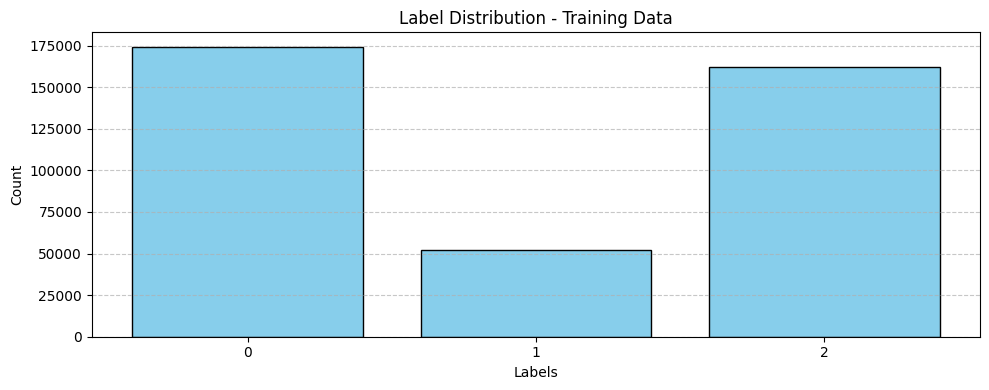

In [16]:
# Checking the label distribution of training data
print('\n\n====== Label Distribution - Training data ======')
unique_labels, counts = np.unique(y_train, return_counts=True)
total = counts.sum()
print(f"{'Label':<10}{'Count':<10}{'Percentage':<10}")
print("-" * 30)
for label, count in zip(unique_labels, counts):
    percentage = (count / total) * 100
    print(f"{label:<10}{count:<10}{percentage:<.2f}%")

print(f"\nTotal samples: {total}")

# Plot histogram for training data
unique_labels, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 4))
plt.bar(unique_labels.astype(str), counts, color='skyblue', edgecolor='black')
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title(f"Label Distribution - Training Data")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Dataset and DataLoader

In [17]:
class Conv1dDataset(Dataset):
    def __init__(self, X, y):
        """
        X expected shape: (N, T, F)  -> convert to (N, C, L) with C=F, L=T
        Transpose to (N, F, T)
        """
        self.X = torch.tensor(X.transpose(0, 2, 1), dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return {"x": self.X[idx], "y": self.y[idx]}

In [18]:
val_dataset = Conv1dDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = Conv1dDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [19]:
def conv_block(in_channels: int, out_channels: int, dropout_p=0.3) -> nn.Module:
    return nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 5,padding='same'),
        nn.BatchNorm1d(out_channels),
        nn.ReLU(),
        nn.Dropout(p=dropout_p)
    )

In [20]:
################ CNN Backbone
class cnn_dropout(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        self.conv1 = conv_block(6, 64, dropout_p)
        self.conv2 = conv_block(64, 128, dropout_p)
        self.conv3 = conv_block(128, 256, dropout_p)
        self.conv4 = conv_block(256, 512, dropout_p)
        self.conv5 = conv_block(512, 1024, dropout_p)
        
        self.global_pool = nn.AdaptiveAvgPool1d(1)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_pool(x)
        return x.view(x.size(0), -1)
 
 
################ Fully connected network
class FC_dropout(nn.Module):
    def __init__(self,input_dim, dropout_p=0.3):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout_p)
        self.fco = nn.Linear(input_dim, NUM_CLASSES)

    def forward(self, x):
        x = self.dropout(x)
        return self.fco(x)

In [21]:
# Loading model weights
backbone_state = torch.load('/kaggle/input/active-learning-subset/backboneSiteA2019.pth')
fc_state = torch.load('/kaggle/input/active-learning-subset/fcSiteA2019.pth')

backbone_state = OrderedDict((k.replace('module.', ''), v) for k, v in backbone_state.items())
fc_state = OrderedDict((k.replace('module.', ''), v) for k, v in fc_state.items())

In [22]:
# Enable dropout at inference/prediction (MC dropout)
def enable_dropout(model):
    """Enable dropout layers during test time."""
    for m in model.modules():
        if isinstance(m, nn.Dropout):
            m.train()  # Keep dropout in training mode

## Evaluation Function

In [23]:
def mc_dropout_eval(backbone, fc, dataloader, T=20):
    backbone.eval()
    fc.eval()
    enable_dropout(backbone)
    enable_dropout(fc)

    all_preds = []
    all_labels = []
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Validation"):
            x = batch["x"].to(DEVICE)
            y = batch["y"].to(DEVICE)
            all_labels.append(y.cpu())

            logits_T = []
            mc_outputs = []
            for _ in range(T):
                feat = backbone(x)
                logits = fc(feat)
                logits_T.append(logits)
                probs = F.softmax(logits, dim=1)  # (B, num_classes)
                mc_outputs.append(probs.unsqueeze(0))  # (1, B, C)

            # Stack and average: (T, B, C) → (B, C)
            logits_T = torch.stack(logits_T, dim=0)  # (T, B, C)
            mc_outputs = torch.cat(mc_outputs, dim=0)  # (T, B, C)
            mc_mean = mc_outputs.mean(dim=0)  # (B, C)

             # ===== Compute loss =====
            ce_t = [F.cross_entropy(l, y, weight=class_weights, reduction="mean") for l in logits_T]
            loss = torch.stack(ce_t).mean()
            batch_size = y.size(0)
            total_loss += loss.item() * batch_size
            total_samples += batch_size

            preds = torch.argmax(mc_mean, dim=1)
            all_preds.append(preds.cpu())

    # Concat all batches
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    # ====== Metrics ======
    kappa = cohen_kappa_score(all_labels.numpy(), all_preds.numpy())
    acc = accuracy_score(all_labels.numpy(), all_preds.numpy())
    avg_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average="macro")
    per_class_f1 = f1_score(all_labels.numpy(), all_preds.numpy(), average=None)

    avg_loss = total_loss / total_samples

    return avg_loss, acc, avg_f1, per_class_f1, kappa

## Acquisition Function

In [24]:
# ============= Predictive Entropy ============= 
def predictive_entropy_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, T=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(T), desc='MC Dropout Simulations (PredEntropy)'):
            logits = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                x_batch = torch.tensor(X_pool[i:i+BATCH_SIZE]).float().permute(0, 2, 1).to(device)  # (B, F, T)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                logits.append(F.softmax(out, dim=1).cpu())
            probs = torch.cat(logits, dim=0)
            mc_probs.append(probs)

    mc_probs = torch.stack(mc_probs)  # Shape: [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # Shape: [N, C]
    entropy = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)

    topk = torch.topk(entropy, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BALD (Bayesian AL by Disagreement) ============= 
def bald_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, T=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (BALD)"):
            logits = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                x_batch = torch.tensor(X_pool[i:i+BATCH_SIZE]).float().permute(0, 2, 1).to(device)  # (B, F, T)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                probs = F.softmax(out, dim=1).cpu()
                logits.append(probs)
            mc_probs.append(torch.cat(logits, dim=0))

    mc_probs = torch.stack(mc_probs)  # [T, N, C]
    avg_probs = mc_probs.mean(dim=0)  # [N, C]

    # Predictive Entropy
    H = -torch.sum(avg_probs * torch.log(avg_probs + 1e-8), dim=1)  # [N]

    # Expected Entropy
    E_H = -torch.sum(mc_probs * torch.log(mc_probs + 1e-8), dim=2).mean(dim=0)  # [N]

    # BALD = H - E_H
    bald_score = H - E_H
    topk = torch.topk(bald_score, k=k).indices
    return [indices[i.item()] for i in topk]



# ============= Variation Ratios ============= 
def variation_ratio_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, T=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    preds = []

    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (VarRatio)"):
            logits = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                x_batch = torch.tensor(X_pool[i:i+BATCH_SIZE]).float().permute(0, 2, 1).to(device)  # (B, F, T)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                pred = torch.argmax(out, dim=1).cpu()
                logits.append(pred)
            preds.append(torch.cat(logits, dim=0))

    preds = torch.stack(preds)  # [T, N]
    mode_preds = torch.mode(preds, dim=0)[0]  # [N]
    agreement = (preds == mode_preds.unsqueeze(0)).sum(dim=0)  # [N]
    variation_ratio = 1 - agreement.float() / T

    topk = torch.topk(variation_ratio, k=k).indices
    return [indices[i.item()] for i in topk]


# ============= BvSB ============= 
def bvsb_sampling(X, model_backbone, model_fc, k, device, unlabeled_pool, T=20):
    model_backbone.eval()
    model_fc.eval()
    enable_dropout(model_backbone)
    enable_dropout(model_fc)

    indices = list(unlabeled_pool)
    X_pool = X[indices]
    mc_probs = []

    with torch.no_grad():
        for _ in tqdm(range(T), desc="MC Dropout Simulations (BvSB)"):
            logits = []
            for i in range(0, len(X_pool), BATCH_SIZE):
                x_batch = torch.tensor(X_pool[i:i+BATCH_SIZE]).float().permute(0, 2, 1).to(device)  # (B, F, T)
                feats = model_backbone(x_batch)
                out = model_fc(feats)
                probs = F.softmax(out, dim=1).cpu()
                logits.append(probs)
            mc_probs.append(torch.cat(logits, dim=0))

    mc_probs = torch.stack(mc_probs)        # [T, N, C]
    avg_probs = mc_probs.mean(dim=0)        # [N, C]

    # Sort class probabilities per sample
    sorted_probs, _ = torch.sort(avg_probs, dim=1)  # [N, C]

    # Best vs Second Best margin = highest prob - second highest prob
    margins = sorted_probs[:, -1] - sorted_probs[:, -2]  # [N]

    # Smaller margins = more uncertainty → select them
    topk = torch.topk(-margins, k=k).indices
    return [indices[i.item()] for i in topk]

In [25]:
# This time, only 2 strategies
sampling_strategies = {
    "predictive_entropy": predictive_entropy_sampling,
    "bald": bald_sampling
    # "variation_ratio": variation_ratio_sampling,
    # "bvsb": bvsb_sampling
}

# Create separate pools and histories for each strategy
strategy_pools = {}
strategy_histories = {}

for name in sampling_strategies:
    strategy_pools[name] = {
        "labeled": set(),
        "unlabeled": set(range(len(X_train)))
    }
    
    strategy_histories[name] = {
        "rounds": [],
        "num_labeled": [],
        "train_accuracy": [],
        "train_loss": [],
        "val_accuracy": [],
        "val_loss": [],
        "avg_f1": [],
        "per_class_f1": [],
        "kappa": []
    }

## Training Loop

In [26]:
all_labels = np.array(y_train)  # shape: (num_samples, H, W) if segmentation

# Flatten labels and count occurrences
flattened = all_labels.flatten()
flattened = flattened[flattened >= 0]
class_counts = np.bincount(flattened, minlength=NUM_CLASSES)
total_pixels = class_counts.sum()

# Inverse frequency (optionally normalize)
class_weights = total_pixels / (NUM_CLASSES * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)
class_weights = torch.log(1 + class_weights)

print(class_weights)

tensor([0.5561, 1.2483, 0.5867], device='cuda:0')


In [27]:
def train(backbone, fc, train_loader, device, optimizer, epochs=5):
    backbone.train()
    fc.train()

    train_accuracies = []
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch in train_loader:
            xt = batch["x"].to(device)
            yt = batch["y"].to(device)

            optimizer.zero_grad()

            features = backbone(xt)
            outputs = fc(features)
            loss = F.cross_entropy(outputs, yt, weight=class_weights)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == yt).sum().item()
            total += yt.size(0)

        avg_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)
        
        if (epoch+1)%5 == 0:    
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Acc: {train_acc*100:.2f}%")

    return train_accuracies, train_losses

## AL Pipeling Loop

In [28]:
# Calculate total and effective samples
total_samples = AL_ROUNDS * QUERY_SIZE + INITIAL_LABELED
effective_samples = INITIAL_LABELED * AL_ROUNDS + QUERY_SIZE * (AL_ROUNDS * (AL_ROUNDS + 1)) // 2  # Sum of 1+2+...+num_rounds

# Nicely formatted print
print("=" * 50)
print(" Active Learning Configuration Summary")
print("=" * 50)
print(f"Stochastic Passes:          {T}")
print(f"Number of Rounds:           {AL_ROUNDS}")
print(f"Initial Labeled Samples:    {INITIAL_LABELED}")
print(f"Query Size per Round:       {QUERY_SIZE}")
print(f"Number of epochs:           {EPOCHS}")
print(f"Total Labeled Samples:      {total_samples}")
print(f"Effective Samples (Total):  {effective_samples}")
print("=" * 50)

 Active Learning Configuration Summary
Stochastic Passes:          10
Number of Rounds:           10
Initial Labeled Samples:    4000
Query Size per Round:       1000
Number of epochs:           20
Total Labeled Samples:      14000
Effective Samples (Total):  95000


In [29]:
for name, query_func in sampling_strategies.items():
    print(f"\n======================")
    print(f" Running strategy: {name.upper()} ")
    print(f"======================")    

    # Re-initializing the model for each strategy
    backbone = cnn_dropout().to(DEVICE)
    fc = FC_dropout(1024).to(DEVICE)
    backbone.load_state_dict(backbone_state)
    fc.load_state_dict(fc_state)

    labeled_pool = strategy_pools[name]["labeled"]
    unlabeled_pool = strategy_pools[name]["unlabeled"]
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    history = strategy_histories[name]

    # Training on initial labeled samples
    initial_labeled = set(np.random.choice(list(unlabeled_pool), INITIAL_LABELED, replace=False))
    labeled_pool.update(initial_labeled)
    unlabeled_pool.difference_update(initial_labeled)
    print('Length of Labeled Pool:', len(labeled_pool))
    print('Length of Unlabeled Pool:', len(unlabeled_pool))

    train_dataset = Conv1dDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    #  Train + Evaluate
    print(f'\n-> Training on {INITIAL_LABELED} initially labeled samples ')
    optimizer = torch.optim.AdamW(list(backbone.parameters()) + list(fc.parameters()), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

    train_acc, train_loss = train(backbone, fc, train_loader, DEVICE, optimizer, epochs=EPOCHS)
    val_loss, val_acc, avg_f1, per_class_f1, kappa = mc_dropout_eval(backbone, fc, val_dataloader, T)
    scheduler.step(val_loss)
    
    print("Per-class F1 scores:", per_class_f1)
    print(f"Validation Accuracy: {val_acc * 100:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f'Kappa: {kappa}')

    history["rounds"].append(0)
    history["num_labeled"].append(len(labeled_pool))
    history["train_accuracy"].append(train_acc[-1])
    history["train_loss"].append(train_loss[-1])
    history["val_accuracy"].append(val_acc)
    history["val_loss"].append(val_loss)
    history["avg_f1"].append(avg_f1)
    history["per_class_f1"].append(per_class_f1.tolist())
    history["kappa"].append(kappa)
    

    for round_num in range(1, AL_ROUNDS + 1):
        print(f"\n--- Round {round_num} [{name}] ---")
        
        # 1. Query k samples
        queried_indices = query_func(
            X=X_train,
            model_backbone=backbone,
            model_fc=fc,
            k=QUERY_SIZE,
            device=DEVICE,
            unlabeled_pool=unlabeled_pool,
            T = T
        )
    
        # 2. Update pools
        new_indices = set(queried_indices) - labeled_pool  # avoid duplication
        labeled_pool.update(new_indices)
        unlabeled_pool.difference_update(new_indices)
        print('Length of Labeled Pool:', len(labeled_pool))
        print('Length of Unlabeled Pool:', len(unlabeled_pool))
        
        # 3. Build train loader
        train_dataset = Conv1dDataset(X_train[list(labeled_pool)], y_train[list(labeled_pool)])
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
        # 4. Train + Evaluate
        optimizer = torch.optim.AdamW(list(backbone.parameters()) + list(fc.parameters()), lr=LR)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

        train_acc, train_loss = train(backbone, fc, train_loader, DEVICE, optimizer, epochs=EPOCHS)
        val_loss, val_acc, avg_f1, per_class_f1, kappa = mc_dropout_eval(backbone, fc, val_dataloader, T)
        scheduler.step(val_loss)

        print("Per-class F1 scores:", per_class_f1)
        print(f"Validation Accuracy: {val_acc * 100:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}")
        print(f"Average F1 Score: {avg_f1:.4f}")
        print(f'Kappa: {kappa}')
        
        # 5. Update history
        history["rounds"].append(round_num)
        history["num_labeled"].append(len(labeled_pool))
        history["train_accuracy"].append(train_acc[-1])
        history["train_loss"].append(train_loss[-1])
        history["val_accuracy"].append(val_acc)
        history["val_loss"].append(val_loss)
        history["avg_f1"].append(avg_f1)
        history["per_class_f1"].append(per_class_f1.tolist())
        history["kappa"].append(kappa)

    
    # Testing the model on test data
    _, acc, avg_f1, per_class_f1, kappa = mc_dropout_eval(backbone, fc, test_dataloader, T)
    print()
    print("=" * 50)
    print(f'Test Results for Strategy {name.upper()}')
    print("=" * 50)
    print(f"Overall Accuracy: {acc * 100:.2f}%")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print("Per-class F1 scores:", per_class_f1)
    print(f'Kappa: {kappa}')
    print("=" * 50)
    print ()

    # Saving the Labeled Pool for each strategy
    save_dir = "approx_BCNN_selected_data"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir, exist_ok=True)
    
    data_file = os.path.join(save_dir, f"approx_BCNN_data_{name}.npz")
    np.savez(
        data_file,
        X=X_train[list(labeled_pool)],
        y=y_train[list(labeled_pool)]
    )
    
    print(f"Saved labeled data for {name} to {data_file}")


 Running strategy: PREDICTIVE_ENTROPY 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 388743
Length of Labeled Pool: 4000
Length of Unlabeled Pool: 384743

-> Training on 4000 initially labeled samples 
Epoch 5/20, Loss: 0.3649, Train Acc: 85.38%
Epoch 10/20, Loss: 0.3240, Train Acc: 86.67%
Epoch 15/20, Loss: 0.2845, Train Acc: 89.22%
Epoch 20/20, Loss: 0.2600, Train Acc: 89.35%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.15it/s]


Per-class F1 scores: [0.88099677 0.86025434 0.88232114]
Validation Accuracy: 87.85%
Validation Loss: 0.3461
Average F1 Score: 0.8745
Kappa: 0.8020873971360947

--- Round 1 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:49<00:00, 16.98s/it]


Length of Labeled Pool: 5000
Length of Unlabeled Pool: 383743
Epoch 5/20, Loss: 0.4090, Train Acc: 81.48%
Epoch 10/20, Loss: 0.3732, Train Acc: 83.60%
Epoch 15/20, Loss: 0.3396, Train Acc: 84.84%
Epoch 20/20, Loss: 0.3579, Train Acc: 84.40%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.21it/s]


Per-class F1 scores: [0.88333077 0.88093346 0.88957212]
Validation Accuracy: 88.56%
Validation Loss: 0.3139
Average F1 Score: 0.8846
Kappa: 0.8131932107945867

--- Round 2 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:49<00:00, 16.94s/it]


Length of Labeled Pool: 6000
Length of Unlabeled Pool: 382743
Epoch 5/20, Loss: 0.4578, Train Acc: 79.32%
Epoch 10/20, Loss: 0.4350, Train Acc: 80.37%
Epoch 15/20, Loss: 0.4141, Train Acc: 81.35%
Epoch 20/20, Loss: 0.3934, Train Acc: 82.68%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.15it/s]


Per-class F1 scores: [0.8946057  0.89948318 0.88958524]
Validation Accuracy: 89.32%
Validation Loss: 0.3186
Average F1 Score: 0.8946
Kappa: 0.8244468034788925

--- Round 3 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:49<00:00, 16.97s/it]


Length of Labeled Pool: 7000
Length of Unlabeled Pool: 381743
Epoch 5/20, Loss: 0.4824, Train Acc: 77.97%
Epoch 10/20, Loss: 0.4432, Train Acc: 79.89%
Epoch 15/20, Loss: 0.4246, Train Acc: 80.90%
Epoch 20/20, Loss: 0.4103, Train Acc: 81.53%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.18it/s]


Per-class F1 scores: [0.89496623 0.90156139 0.89731039]
Validation Accuracy: 89.69%
Validation Loss: 0.3251
Average F1 Score: 0.8979
Kappa: 0.8306968571665867

--- Round 4 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:49<00:00, 16.92s/it]


Length of Labeled Pool: 8000
Length of Unlabeled Pool: 380743
Epoch 5/20, Loss: 0.4696, Train Acc: 78.11%
Epoch 10/20, Loss: 0.4397, Train Acc: 79.88%
Epoch 15/20, Loss: 0.4236, Train Acc: 81.38%
Epoch 20/20, Loss: 0.3903, Train Acc: 82.36%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.15it/s]


Per-class F1 scores: [0.89866228 0.90821985 0.89728789]
Validation Accuracy: 89.94%
Validation Loss: 0.3262
Average F1 Score: 0.9014
Kappa: 0.8345813967135831

--- Round 5 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:48<00:00, 16.87s/it]


Length of Labeled Pool: 9000
Length of Unlabeled Pool: 379743
Epoch 5/20, Loss: 0.4616, Train Acc: 79.00%
Epoch 10/20, Loss: 0.4344, Train Acc: 81.04%
Epoch 15/20, Loss: 0.4098, Train Acc: 82.22%
Epoch 20/20, Loss: 0.3868, Train Acc: 82.81%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.15it/s]


Per-class F1 scores: [0.90133904 0.90826245 0.90077972]
Validation Accuracy: 90.20%
Validation Loss: 0.3558
Average F1 Score: 0.9035
Kappa: 0.8387635756570737

--- Round 6 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:48<00:00, 16.82s/it]


Length of Labeled Pool: 10000
Length of Unlabeled Pool: 378743
Epoch 5/20, Loss: 0.4515, Train Acc: 79.70%
Epoch 10/20, Loss: 0.4261, Train Acc: 81.14%
Epoch 15/20, Loss: 0.3993, Train Acc: 82.41%
Epoch 20/20, Loss: 0.3756, Train Acc: 83.17%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.15it/s]


Per-class F1 scores: [0.89721377 0.90985102 0.89799129]
Validation Accuracy: 89.93%
Validation Loss: 0.3616
Average F1 Score: 0.9017
Kappa: 0.8342770351279167

--- Round 7 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:47<00:00, 16.74s/it]


Length of Labeled Pool: 11000
Length of Unlabeled Pool: 377743
Epoch 5/20, Loss: 0.4206, Train Acc: 81.38%
Epoch 10/20, Loss: 0.4089, Train Acc: 82.13%
Epoch 15/20, Loss: 0.3801, Train Acc: 83.61%
Epoch 20/20, Loss: 0.3602, Train Acc: 84.24%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.14it/s]


Per-class F1 scores: [0.89686119 0.90904994 0.89645272]
Validation Accuracy: 89.84%
Validation Loss: 0.3832
Average F1 Score: 0.9008
Kappa: 0.832988565713763

--- Round 8 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:47<00:00, 16.74s/it]


Length of Labeled Pool: 12000
Length of Unlabeled Pool: 376743
Epoch 5/20, Loss: 0.4044, Train Acc: 82.27%
Epoch 10/20, Loss: 0.3870, Train Acc: 82.93%
Epoch 15/20, Loss: 0.3614, Train Acc: 84.31%
Epoch 20/20, Loss: 0.3406, Train Acc: 85.28%


Validation: 100%|██████████| 1519/1519 [00:38<00:00, 39.88it/s]


Per-class F1 scores: [0.89748292 0.9092212  0.89980788]
Validation Accuracy: 90.01%
Validation Loss: 0.4110
Average F1 Score: 0.9022
Kappa: 0.8357577100148668

--- Round 9 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:46<00:00, 16.63s/it]


Length of Labeled Pool: 13000
Length of Unlabeled Pool: 375743
Epoch 5/20, Loss: 0.4012, Train Acc: 82.32%
Epoch 10/20, Loss: 0.3731, Train Acc: 83.78%
Epoch 15/20, Loss: 0.3498, Train Acc: 84.98%
Epoch 20/20, Loss: 0.3711, Train Acc: 84.42%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.15it/s]


Per-class F1 scores: [0.89857818 0.91241461 0.89778159]
Validation Accuracy: 90.01%
Validation Loss: 0.3938
Average F1 Score: 0.9029
Kappa: 0.8354976561368824

--- Round 10 [predictive_entropy] ---


MC Dropout Simulations (PredEntropy): 100%|██████████| 10/10 [02:46<00:00, 16.60s/it]


Length of Labeled Pool: 14000
Length of Unlabeled Pool: 374743
Epoch 5/20, Loss: 0.3858, Train Acc: 83.22%
Epoch 10/20, Loss: 0.3626, Train Acc: 84.76%
Epoch 15/20, Loss: 0.3553, Train Acc: 84.89%
Epoch 20/20, Loss: 0.3333, Train Acc: 85.72%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.13it/s]


Per-class F1 scores: [0.90117918 0.91177251 0.89830087]
Validation Accuracy: 90.14%
Validation Loss: 0.4073
Average F1 Score: 0.9038
Kappa: 0.8377150522106065


Validation: 100%|██████████| 22778/22778 [09:28<00:00, 40.08it/s]



Test Results for Strategy PREDICTIVE_ENTROPY
Overall Accuracy: 90.17%
Average F1 Score: 0.9042
Per-class F1 scores: [0.90141839 0.91289523 0.89833596]
Kappa: 0.8381642683290472

Saved labeled data for predictive_entropy to approx_BCNN_selected_data/approx_BCNN_data_predictive_entropy.npz

 Running strategy: BALD 
Length of Labeled Pool: 0
Length of Unlabeled Pool: 388743
Length of Labeled Pool: 4000
Length of Unlabeled Pool: 384743

-> Training on 4000 initially labeled samples 
Epoch 5/20, Loss: 0.3986, Train Acc: 83.60%
Epoch 10/20, Loss: 0.3331, Train Acc: 86.30%
Epoch 15/20, Loss: 0.3095, Train Acc: 87.62%
Epoch 20/20, Loss: 0.2853, Train Acc: 88.58%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.07it/s]


Per-class F1 scores: [0.87893045 0.90124031 0.88213388]
Validation Accuracy: 88.33%
Validation Loss: 0.3380
Average F1 Score: 0.8874
Kappa: 0.8074394415783329

--- Round 1 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:49<00:00, 17.00s/it]


Length of Labeled Pool: 5000
Length of Unlabeled Pool: 383743
Epoch 5/20, Loss: 0.3285, Train Acc: 87.46%
Epoch 10/20, Loss: 0.2897, Train Acc: 88.36%
Epoch 15/20, Loss: 0.2456, Train Acc: 90.20%
Epoch 20/20, Loss: 0.2415, Train Acc: 90.16%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.17it/s]


Per-class F1 scores: [0.88937282 0.9078196  0.88115319]
Validation Accuracy: 88.85%
Validation Loss: 0.3235
Average F1 Score: 0.8928
Kappa: 0.8156435605057081

--- Round 2 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:49<00:00, 16.96s/it]


Length of Labeled Pool: 6000
Length of Unlabeled Pool: 382743
Epoch 5/20, Loss: 0.2556, Train Acc: 89.82%
Epoch 10/20, Loss: 0.2331, Train Acc: 90.52%
Epoch 15/20, Loss: 0.2281, Train Acc: 91.03%
Epoch 20/20, Loss: 0.2108, Train Acc: 91.67%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.21it/s]


Per-class F1 scores: [0.89612904 0.91043916 0.89222   ]
Validation Accuracy: 89.64%
Validation Loss: 0.3174
Average F1 Score: 0.8996
Kappa: 0.829207271557987

--- Round 3 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:49<00:00, 16.91s/it]


Length of Labeled Pool: 7000
Length of Unlabeled Pool: 381743
Epoch 5/20, Loss: 0.2657, Train Acc: 89.27%
Epoch 10/20, Loss: 0.2455, Train Acc: 89.99%
Epoch 15/20, Loss: 0.2372, Train Acc: 90.14%
Epoch 20/20, Loss: 0.2202, Train Acc: 91.07%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.17it/s]


Per-class F1 scores: [0.89849611 0.91794126 0.89173875]
Validation Accuracy: 89.83%
Validation Loss: 0.3267
Average F1 Score: 0.9027
Kappa: 0.8316167105338435

--- Round 4 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:48<00:00, 16.86s/it]


Length of Labeled Pool: 8000
Length of Unlabeled Pool: 380743
Epoch 5/20, Loss: 0.2614, Train Acc: 88.69%
Epoch 10/20, Loss: 0.2379, Train Acc: 89.89%
Epoch 15/20, Loss: 0.2227, Train Acc: 90.76%
Epoch 20/20, Loss: 0.2119, Train Acc: 91.00%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.11it/s]


Per-class F1 scores: [0.88518669 0.91695038 0.88963211]
Validation Accuracy: 89.14%
Validation Loss: 0.3274
Average F1 Score: 0.8973
Kappa: 0.8213650783788697

--- Round 5 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:48<00:00, 16.84s/it]


Length of Labeled Pool: 9000
Length of Unlabeled Pool: 379743
Epoch 5/20, Loss: 0.2553, Train Acc: 89.32%
Epoch 10/20, Loss: 0.2416, Train Acc: 89.94%
Epoch 15/20, Loss: 0.2179, Train Acc: 91.10%
Epoch 20/20, Loss: 0.2132, Train Acc: 91.06%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.09it/s]


Per-class F1 scores: [0.90161034 0.91737111 0.89813515]
Validation Accuracy: 90.23%
Validation Loss: 0.3240
Average F1 Score: 0.9057
Kappa: 0.8390661092665267

--- Round 6 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:48<00:00, 16.80s/it]


Length of Labeled Pool: 10000
Length of Unlabeled Pool: 378743
Epoch 5/20, Loss: 0.2628, Train Acc: 88.89%
Epoch 10/20, Loss: 0.2500, Train Acc: 89.35%
Epoch 15/20, Loss: 0.2203, Train Acc: 90.55%
Epoch 20/20, Loss: 0.2218, Train Acc: 90.72%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.21it/s]


Per-class F1 scores: [0.90157622 0.91864097 0.90085572]
Validation Accuracy: 90.36%
Validation Loss: 0.3319
Average F1 Score: 0.9070
Kappa: 0.8412972576378722

--- Round 7 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:47<00:00, 16.71s/it]


Length of Labeled Pool: 11000
Length of Unlabeled Pool: 377743
Epoch 5/20, Loss: 0.2699, Train Acc: 88.58%
Epoch 10/20, Loss: 0.2469, Train Acc: 89.92%
Epoch 15/20, Loss: 0.2262, Train Acc: 90.75%
Epoch 20/20, Loss: 0.2242, Train Acc: 90.54%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.03it/s]


Per-class F1 scores: [0.90205585 0.91771598 0.90090112]
Validation Accuracy: 90.37%
Validation Loss: 0.3237
Average F1 Score: 0.9069
Kappa: 0.8414542622789163

--- Round 8 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:46<00:00, 16.68s/it]


Length of Labeled Pool: 12000
Length of Unlabeled Pool: 376743
Epoch 5/20, Loss: 0.2543, Train Acc: 89.41%
Epoch 10/20, Loss: 0.2501, Train Acc: 89.68%
Epoch 15/20, Loss: 0.2329, Train Acc: 90.48%
Epoch 20/20, Loss: 0.2183, Train Acc: 91.03%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.18it/s]


Per-class F1 scores: [0.90740379 0.92340343 0.90528385]
Validation Accuracy: 90.86%
Validation Loss: 0.3292
Average F1 Score: 0.9120
Kappa: 0.8493148355789486

--- Round 9 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:46<00:00, 16.66s/it]


Length of Labeled Pool: 13000
Length of Unlabeled Pool: 375743
Epoch 5/20, Loss: 0.2652, Train Acc: 88.80%
Epoch 10/20, Loss: 0.2356, Train Acc: 89.88%
Epoch 15/20, Loss: 0.2233, Train Acc: 90.70%
Epoch 20/20, Loss: 0.2303, Train Acc: 90.25%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.13it/s]


Per-class F1 scores: [0.9074955  0.91842465 0.9048204 ]
Validation Accuracy: 90.79%
Validation Loss: 0.3128
Average F1 Score: 0.9102
Kappa: 0.8483661492635943

--- Round 10 [bald] ---


MC Dropout Simulations (BALD): 100%|██████████| 10/10 [02:45<00:00, 16.59s/it]


Length of Labeled Pool: 14000
Length of Unlabeled Pool: 374743
Epoch 5/20, Loss: 0.2572, Train Acc: 89.29%
Epoch 10/20, Loss: 0.2443, Train Acc: 89.70%
Epoch 15/20, Loss: 0.2337, Train Acc: 90.28%
Epoch 20/20, Loss: 0.2329, Train Acc: 90.10%


Validation: 100%|██████████| 1519/1519 [00:37<00:00, 40.20it/s]


Per-class F1 scores: [0.90562043 0.92181101 0.90296085]
Validation Accuracy: 90.67%
Validation Loss: 0.3290
Average F1 Score: 0.9101
Kappa: 0.8462442282534675


Validation: 100%|██████████| 22778/22778 [09:27<00:00, 40.14it/s]



Test Results for Strategy BALD
Overall Accuracy: 90.71%
Average F1 Score: 0.9104
Per-class F1 scores: [0.90637979 0.92161335 0.90329373]
Kappa: 0.8470145347113627

Saved labeled data for bald to approx_BCNN_selected_data/approx_BCNN_data_bald.npz


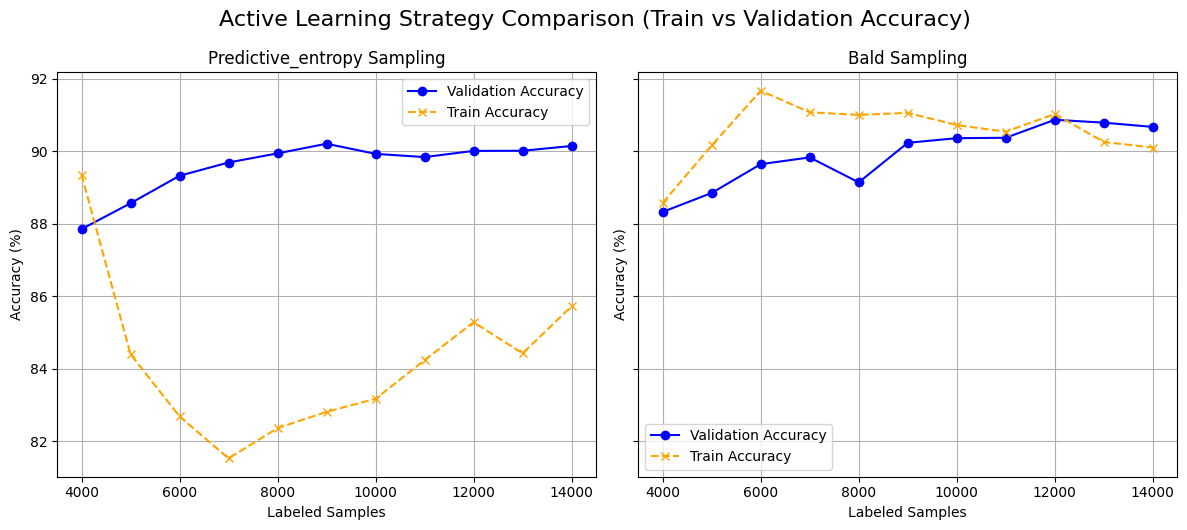

In [30]:
# Accuracy Plot: Train vs Val
n = len(sampling_strategies)  
fig, axs = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_accs = [a * 100 for a in history["val_accuracy"]]
    train_accs = [a * 100 for a in history["train_accuracy"]]

    axs[i].plot(history["num_labeled"], val_accs, marker="o", label="Validation Accuracy", color="blue")
    axs[i].plot(history["num_labeled"], train_accs, marker="x", linestyle="--", label="Train Accuracy", color="orange")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Accuracy)", fontsize=16, y=1.05)
plt.show()

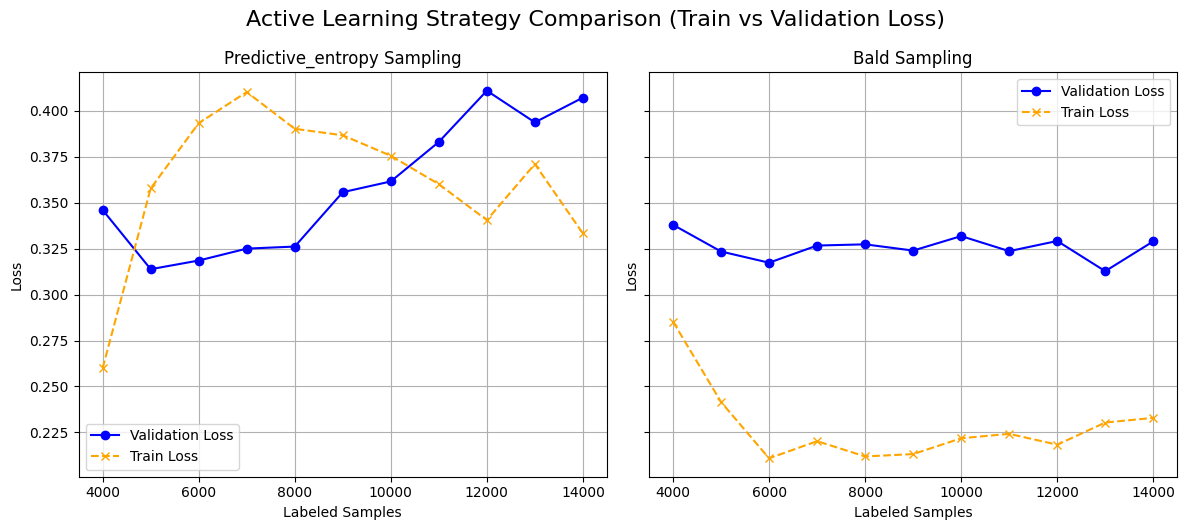

In [31]:
# Loss Plot: Train vs Val
n = len(sampling_strategies)  
fig, axs = plt.subplots(1, n, figsize=(6*n, 5), sharey=True)

for i, (name, history) in enumerate(strategy_histories.items()):
    val_loss = [l for l in history["val_loss"]]
    train_loss = [l for l in history["train_loss"]]

    axs[i].plot(history["num_labeled"], val_loss, marker="o", label="Validation Loss", color="blue")
    axs[i].plot(history["num_labeled"], train_loss, marker="x", linestyle="--", label="Train Loss", color="orange")

    axs[i].set_title(f"{name.capitalize()} Sampling")
    axs[i].set_xlabel("Labeled Samples")
    axs[i].set_ylabel("Loss")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.suptitle("Active Learning Strategy Comparison (Train vs Validation Loss)", fontsize=16, y=1.05)
plt.show()

## Saving the Results

In [32]:
# After your active learning loop finishes for all strategies:
output_file = "active_learning_history_approxBCNN.xlsx"

with pd.ExcelWriter(output_file, engine="openpyxl") as writer:
    for strategy_name, history in strategy_histories.items():
        # Convert history dict to DataFrame
        df = pd.DataFrame({
            "round": history["rounds"],
            "num_labeled": history["num_labeled"],
            "train_accuracy": history["train_accuracy"],
            "train_loss": history["train_loss"],
            "val_accuracy": history["val_accuracy"],
            "val_loss": history["val_loss"],
            "avg_f1": history["avg_f1"],
            "kappa": history["kappa"],
            # store per-class f1 as string so Excel can hold it
            "per_class_f1": [",".join(map(str, f1)) for f1 in history["per_class_f1"]]
        })

        # Save each strategy history in its own sheet
        df.to_excel(writer, sheet_name=strategy_name, index=False)

print(f"Saved history of all strategies to {output_file}")

Saved history of all strategies to active_learning_history_approxBCNN.xlsx


In [33]:
# Zip the folder
shutil.make_archive("approx_BCNN_selected_data", 'zip', "approx_BCNN_selected_data")

'/kaggle/working/approx_BCNN_selected_data.zip'

In [34]:
FileLink("approx_BCNN_selected_data.zip")

/kaggle/working/approx_BCNN_selected_data.zip

<hr>